In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from IPython.core.display_functions import display
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

pd.options.display.float_format = '{:.3f}'.format

In [21]:
df = pd.read_excel("./data/COVID-19-Constructed-Dataset-(PANEL).xlsx")  #read csv file and store in df

df.describe()

,studentID,school,gradelevel,covidpos,householdincome,freelunch,numcomputers,familysize,fathereduc,mothereduc,readingscore,writingscore,mathscore,readingscoreSL,writingscoreSL,mathscoreSL,timeperiod
count,8400.000,8400.000,8400.000,8400.000,8400.000,8400.000,8400.000,8400.000,8400.000,8400.000,8400.000,8400.000,8400.000,8400.000,8400.000,8400.000,8400.000
mean,700.500,0.500,9.000,0.331,84290.222,0.846,2.324,2.071,1.334,1.264,73.853,76.442,74.687,70.829,72.822,71.445,2.500
std,404.169,0.500,2.000,0.471,37752.483,0.361,1.617,1.030,0.826,0.817,13.295,14.163,13.281,13.409,13.323,13.529,1.708
min,1.000,0.000,6.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,15.320,26.046,25.571,13.234,23.667,27.352,0.000
25%,350.750,0.000,7.000,0.000,53210.645,1.000,1.000,1.000,1.000,1.000,66.026,67.377,65.367,62.744,64.901,61.851,1.000
50%,700.500,0.500,9.000,0.000,85214.332,1.000,2.000,2.000,1.000,1.000,75.305,78.457,75.580,72.488,75.533,72.003,2.500
75%,1050.250,1.000,11.000,1.000,115975.230,1.000,4.000,3.000,2.000,2.000,83.212,87.097,84.575,80.393,82.404,81.735,4.000
max,1400.000,1.000,12.000,1.000,179296.531,1.000,5.000,5.000,4.000,4.000,100.000,100.000,100.000,100.000,100.000,100.000,5.000


# 3. Preprocessing
### 3-1. Categorical Data change to Numeric data

In [22]:
# Categorical Data change to Numeric Data
# 0 = Female, 1 = Male
encoder = OrdinalEncoder(dtype=np.int64)
X = pd.DataFrame(df['gender'])
encoder.fit(X)

# Deep copy (원본 데이터는 유지 한채로 복제본 생성)
data_select = df.copy()
data_select['gender'] = pd.DataFrame(encoder.transform(X))

# Verify the data has been changed appropriately
data_select

,studentID,school,gradelevel,gender,covidpos,householdincome,freelunch,numcomputers,familysize,fathereduc,mothereduc,readingscore,writingscore,mathscore,readingscoreSL,writingscoreSL,mathscoreSL,timeperiod
0,1,0,6,1,1,59065.137,0,5,3,1,0,73.394,68.847,86.906,84.651,83.348,71.108,2
1,1,0,6,1,1,59065.137,0,5,3,1,0,62.566,73.258,56.995,77.571,74.594,57.717,4
2,1,0,6,1,1,59065.137,0,5,3,1,0,79.966,67.070,56.612,87.660,80.293,85.021,1
3,1,0,6,1,1,59065.137,0,5,3,1,0,68.552,55.633,73.728,69.650,48.294,86.596,3
4,1,0,6,1,1,59065.137,0,5,3,1,0,82.541,87.166,65.316,68.990,85.802,65.638,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8395,1400,1,12,1,1,65783.633,1,2,3,3,0,73.328,67.403,87.349,70.828,64.903,84.849,0
8396,1400,1,12,1,1,65783.633,1,2,3,3,3,58.970,84.165,64.041,56.470,81.665,61.541,2
8397,1400,1,12,1,1,65783.633,1,2,3,3,3,51.975,82.905,77.368,49.475,80.405,74.868,3
8398,1400,1,12,1,1,65783.633,1,2,3,3,3,64.104,47.847,81.086,61.604,45.347,78.586,1


In [23]:
# timeperiod를 학기 대신 대면, 비대면 강의 여부로 구분
# 0 = 대면, 1 = 비대면
for i in range(len(data_select)):
    sumOnline = 0
    sumNonOnline = 0
    if data_select.loc[i, 'timeperiod'] < 3:
        data_select.loc[i, 'timeperiod'] = 0
    else:
        data_select.loc[i, 'timeperiod'] = 1

# dataFrame column name change
data_select.rename(columns={'timeperiod': 'online'}, inplace=True)

# Display data for appropriately checking
data_select

,studentID,school,gradelevel,gender,covidpos,householdincome,freelunch,numcomputers,familysize,fathereduc,mothereduc,readingscore,writingscore,mathscore,readingscoreSL,writingscoreSL,mathscoreSL,online
0,1,0,6,1,1,59065.137,0,5,3,1,0,73.394,68.847,86.906,84.651,83.348,71.108,0
1,1,0,6,1,1,59065.137,0,5,3,1,0,62.566,73.258,56.995,77.571,74.594,57.717,1
2,1,0,6,1,1,59065.137,0,5,3,1,0,79.966,67.070,56.612,87.660,80.293,85.021,0
3,1,0,6,1,1,59065.137,0,5,3,1,0,68.552,55.633,73.728,69.650,48.294,86.596,1
4,1,0,6,1,1,59065.137,0,5,3,1,0,82.541,87.166,65.316,68.990,85.802,65.638,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8395,1400,1,12,1,1,65783.633,1,2,3,3,0,73.328,67.403,87.349,70.828,64.903,84.849,0
8396,1400,1,12,1,1,65783.633,1,2,3,3,3,58.970,84.165,64.041,56.470,81.665,61.541,0
8397,1400,1,12,1,1,65783.633,1,2,3,3,3,51.975,82.905,77.368,49.475,80.405,74.868,1
8398,1400,1,12,1,1,65783.633,1,2,3,3,3,64.104,47.847,81.086,61.604,45.347,78.586,0


### 3-2. Deriving Features from Existing Features
#### 3-2-1. Make new feature from some features

In [24]:
# 시험의 과목 성적을 합한 평균을 구함
data_select['total'] = (data_select['readingscore'] + data_select['writingscore'] + data_select[
    'mathscore'] + data_select['readingscoreSL'] + data_select['writingscoreSL'] + data_select[
                            'mathscoreSL']) / 6

# Each grade data is dropped because the average of the total grade was obtained
dropCol = ['readingscore', 'writingscore', 'mathscore', 'readingscoreSL', 'writingscoreSL', 'mathscoreSL', 'covidpos']
data_select = data_select.drop(columns=dropCol)

data_select

,studentID,school,gradelevel,gender,householdincome,freelunch,numcomputers,familysize,fathereduc,mothereduc,online,total
0,1,0,6,1,59065.137,0,5,3,1,0,0,78.042
1,1,0,6,1,59065.137,0,5,3,1,0,1,67.117
2,1,0,6,1,59065.137,0,5,3,1,0,0,76.104
3,1,0,6,1,59065.137,0,5,3,1,0,1,67.076
4,1,0,6,1,59065.137,0,5,3,1,0,0,75.909
...,...,...,...,...,...,...,...,...,...,...,...,...
8395,1400,1,12,1,65783.633,1,2,3,3,0,0,74.777
8396,1400,1,12,1,65783.633,1,2,3,3,3,0,67.809
8397,1400,1,12,1,65783.633,1,2,3,3,3,1,69.500
8398,1400,1,12,1,65783.633,1,2,3,3,3,0,63.095


In [25]:
# 각 학기별 데이터에서 학생 별 데이터 (대면, 비대면)에 따른 성적 데이터를 저장해둘 데이터프레임 생성
data_transform = (data_select.iloc[:, :11]).copy()
data_transform.drop_duplicates(['studentID'], inplace=True)  # 중복되는 학생 ID를 가진 dataset 삭제
data_transform.reset_index(inplace=True)  # 인덱스 초기화
data_transform.drop(columns=['index'], inplace=True)  # index column 제거

# 학생 당 (대면, 비대면)에 따른 성적 평균 합 구함
for i in range(1, len(data_transform) + 1):
    condition0 = (data_select.studentID == i) & (data_select.online == 0)
    condition1 = (data_select.studentID == i) & (data_select.online == 1)
    temp0 = data_select.loc[condition0]
    temp1 = data_select.loc[condition1]
    data_transform.loc[i - 1, "totalNotOnline"] = (temp0.loc[:, "total"].sum() / 3)
    data_transform.loc[i - 1, "totalOnline"] = (temp1.loc[:, "total"].sum() / 3)
    data_transform.loc[i - 1, "differ"] = data_transform.loc[i - 1, "totalNotOnline"] - data_transform.loc[
        i - 1, "totalOnline"]

# Display data for appropriately checking
data_transform

,studentID,school,gradelevel,gender,householdincome,freelunch,numcomputers,familysize,fathereduc,mothereduc,online,totalNotOnline,totalOnline,differ
0,1,0,6,1,59065.137,0,5,3,1,0,0,76.685,67.317,9.368
1,2,0,6,1,107480.086,1,4,1,1,1,0,77.301,69.185,8.116
2,3,0,6,1,79800.844,1,0,2,1,1,0,80.267,68.905,11.362
3,4,0,6,1,125976.164,1,2,3,1,2,1,85.052,75.503,9.549
4,5,0,6,0,110744.156,1,5,2,0,1,1,80.709,70.265,10.444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,1396,1,12,0,19891.385,0,2,2,1,1,0,67.364,61.227,6.137
1396,1397,1,12,0,24009.490,0,1,1,1,1,0,69.427,55.968,13.459
1397,1398,1,12,1,35121.309,1,1,4,2,1,1,73.711,69.847,3.865
1398,1399,1,12,1,54383.434,1,2,2,1,1,0,77.285,67.355,9.930


#### 3-2-2. Make new feature from 'total' column using clustering

In [37]:
# K-mean Clustering + Scaling
def clustering_scaling(i, scaler):
    data = data_transform_list[i]

    # Clustering about
    column_list = ["differ"]
    data_scale = scaler.fit_transform(data.loc[:, column_list])  #data scaling
    model = KMeans(n_clusters=3, random_state=42)
    model.fit(data_scale)  # learning scaling data
    data['differ_level'] = model.fit_predict(data_scale)  # save each clustering data

    # Clustering about
    column_list2 = ["totalNotOnline", "totalOnline"]
    data_scale2 = scaler.fit_transform(data.loc[:, column_list2])  #data scaling
    model2 = KMeans(n_clusters=3, random_state=42)
    model2.fit(data_scale2)  # learning scaling data
    data['score_level'] = model2.fit_predict(data_scale2)  # save each clustering data

    # Clustering about
    column_list3 = ["differ_level", "score_level"]
    data_scale3 = scaler.fit_transform(data.loc[:, column_list3])  #data scaling
    model3 = KMeans(n_clusters=3, random_state=42)
    model3.fit(data_scale3)  # learning scaling data
    data['level'] = model3.fit_predict(data_scale3)  # save each clustering data

    plt.figure(figsize=(8, 8))

    for i in range(3):
        plt.scatter(data.loc[data['level'] == i, 'totalNotOnline'],
                    data.loc[data['level'] == i, 'differ'],
                    label='differ_level ' + str(i))

    plt.legend()
    plt.title(str(scaler))
    plt.xlabel('totalNotOnline', size=12)
    plt.ylabel('totalOnline', size=12)
    plt.show()

    print(data.groupby('level').size())

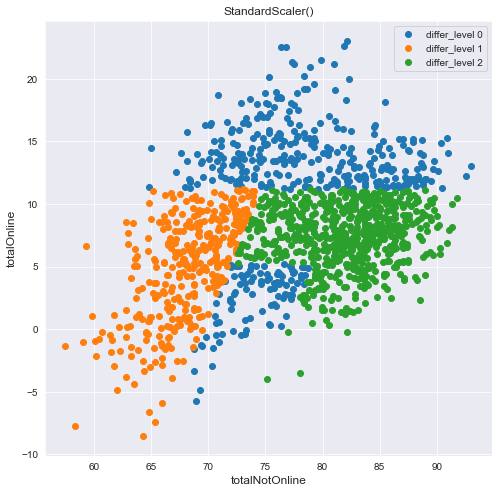

level
0    406
1    345
2    649
dtype: int64


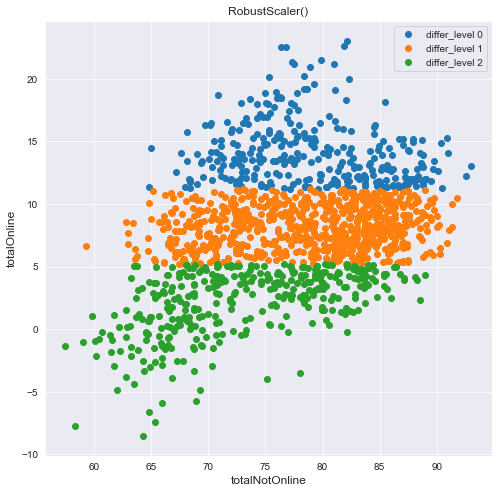

level
0    308
1    727
2    365
dtype: int64


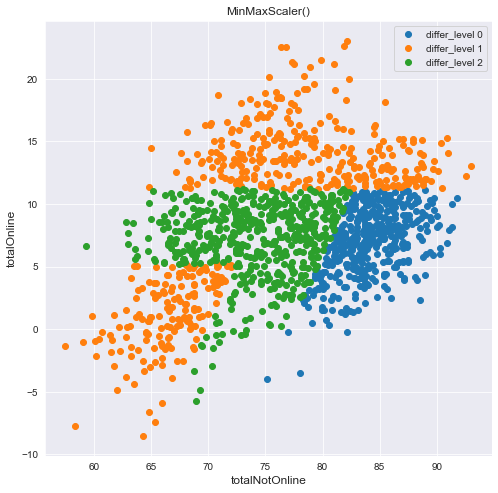

level
0    426
1    470
2    504
dtype: int64


In [38]:
data_transform_std = data_transform.copy()
data_transform_robust = data_transform.copy()
data_transform_minmax = data_transform.copy()
data_transform_list = [data_transform_std, data_transform_robust, data_transform_minmax]

scaler_list = [StandardScaler(), RobustScaler(), MinMaxScaler()]

for i in range(3):
    clustering_scaling(i, scaler_list[i])

In [39]:
# Scaler + SelectKBest
def seletKBest_scaling(data, scaler):
    x = data.iloc[:, 1:-2]  # id, differ, level 제외
    x.drop(['gradelevel'], axis=1, inplace=True)  # gradelevel 요소 제외
    y = data.loc[:, "level"]  # level
    scalerTemp = pd.DataFrame(scaler.fit_transform(x))

    scalerTemp.columns = [x.columns]

    bestfeatures = SelectKBest(score_func=f_regression, k=5)
    fit = bestfeatures.fit(x, y)
    dfcolumns = pd.DataFrame(x.columns)
    dfscores = pd.DataFrame(fit.scores_)

    featureScores = pd.concat([dfcolumns, dfscores], axis=1)
    featureScores.columns = ['Features', 'Score']

    return featureScores.nlargest(10, 'Score')

In [29]:
for i in range(3):
    print(scaler_list[i])
    print(seletKBest_scaling(data_transform_list[i], scaler_list[i]))
    print()

StandardScaler()
           Features    Score
12     differ_level 2585.556
10      totalOnline  567.625
0            school  346.994
2   householdincome  291.243
9    totalNotOnline  169.362
11           differ  149.399
4      numcomputers   87.977
3         freelunch   60.325
6        fathereduc    6.482
7        mothereduc    0.162

RobustScaler()
          Features    Score
11          differ 5266.439
12    differ_level  225.229
10     totalOnline  132.143
9   totalNotOnline  129.282
7       mothereduc    2.244
4     numcomputers    1.345
6       fathereduc    0.682
8           online    0.220
3        freelunch    0.161
1           gender    0.069

MinMaxScaler()
           Features   Score
10      totalOnline 650.836
9    totalNotOnline 639.568
2   householdincome 563.262
0            school 532.798
4      numcomputers 135.622
3         freelunch  62.681
6        fathereduc  23.959
12     differ_level   5.934
5        familysize   2.801
1            gender   2.334



# 4. Modeling
### 4-1. Linear Regression each scaling & Evaluation

In [30]:
def linearRegScaling(scaler, type, testSize, largeColumns):
    data_scale = scaler.fit_transform(data_transform_list[type].loc[:, largeColumns])  #data scaling

    model = KMeans(n_clusters=3, random_state=42)
    model.fit(data_scale)  # learning scaling data
    data_transform_list[type]['predict'] = model.fit_predict(data_scale)  # save each clustering data

    x = data_scale # school, totalNotOnline columns
    y = data_transform_list[type].loc[:, "level"]  # level columns

    reg = linear_model.LinearRegression()

    # Split the dataset into training and testing
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=testSize, random_state=42, shuffle=True)
    reg.fit(x_train, y_train)

    # Compute data and find result
    resultTrainScore = reg.score(x_train, y_train)
    resultTestScore = reg.score(x_test, y_test)

    # data collect
    return resultTrainScore, resultTestScore

In [31]:
# Split the dataset train:test & scaler
split = [0.1, 0.2, 0.3]
scaler = [StandardScaler(), RobustScaler(), MinMaxScaler()]

# 새로운 빈 데이터 프레임 생성
resultBestScaler = pd.DataFrame(index=range(0, 9),
                                columns=["Scaler", "Train", "Test", "TrainSet Score", "TestSet Score"])

largeColumns1 = ("school", "totalNotOnline")
j = 0
for i in range(len(scaler)):
    for k in range(len(split)):
        resultTrainScore, resultTestScore = linearRegScaling(scaler[i], i, split[k], largeColumns1)
        resultBestScaler.iloc[j] = [str(scaler[i]), str(1 - split[k]), str(split[k]), resultTrainScore, resultTestScore]
        j += 1

display(resultBestScaler)

,Scaler,Train,Test,TrainSet Score,TestSet Score
0,StandardScaler(),0.9,0.1,0.206,0.154
1,StandardScaler(),0.8,0.2,0.213,0.153
2,StandardScaler(),0.7,0.3,0.209,0.183
3,RobustScaler(),0.9,0.1,0.242,0.182
4,RobustScaler(),0.8,0.2,0.246,0.200
5,RobustScaler(),0.7,0.3,0.239,0.230
6,MinMaxScaler(),0.9,0.1,0.332,0.312
7,MinMaxScaler(),0.8,0.2,0.329,0.331
8,MinMaxScaler(),0.7,0.3,0.342,0.300


In [32]:
# Split the dataset train:test & scaler
split = [0.1, 0.2, 0.3]
scaler = [StandardScaler(), RobustScaler(), MinMaxScaler()]

# 새로운 빈 데이터 프레임 생성
resultBestScaler = pd.DataFrame(index=range(0, 9),
                                columns=["Scaler", "Train", "Test", "TrainSet Score", "TestSet Score"])

largeColumns2 = ("school", "totalNotOnline","householdincome")
j = 0
for i in range(len(scaler)):
    for k in range(len(split)):
        resultTrainScore, resultTestScore = linearRegScaling(scaler[i], i, split[k], largeColumns2)
        resultBestScaler.iloc[j] = [str(scaler[i]), str(1 - split[k]), str(split[k]), resultTrainScore, resultTestScore]
        j += 1

display(resultBestScaler)

,Scaler,Train,Test,TrainSet Score,TestSet Score
0,StandardScaler(),0.9,0.1,0.214,0.166
1,StandardScaler(),0.8,0.2,0.217,0.175
2,StandardScaler(),0.7,0.3,0.212,0.200
3,RobustScaler(),0.9,0.1,0.257,0.222
4,RobustScaler(),0.8,0.2,0.259,0.231
5,RobustScaler(),0.7,0.3,0.253,0.252
6,MinMaxScaler(),0.9,0.1,0.344,0.340
7,MinMaxScaler(),0.8,0.2,0.344,0.341
8,MinMaxScaler(),0.7,0.3,0.358,0.308


### 4-2. Model Evaluation Metrics for Regression

In [33]:
# Split the dataset into 5 subsets of equal size
def modelEvaluation(type, largeColumns):
    data_scale = data_transform_list[type].loc[:, largeColumns]  #data scaling

    x = scaler_list[type].fit_transform(data_scale)  # "totalNotOnline", "totalOnline" columns data
    y = data_transform_list[type].loc[:, "differ_level"]  # level columns

    reg = linear_model.LinearRegression()
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)
    reg.fit(x_train, y_train)
    y_pred = pd.DataFrame(reg.predict(x_test))

    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_absolute_error(y_test, y_pred))

    return mae, mse, rmse

In [34]:
# 새로운 빈 데이터 프레임 생성
evaluationMetrix = pd.DataFrame(index=range(0, 3),
                                columns=["Scaler", "MAE", "MSE", "RMSE"])

for i in range(3):  # StandardScaler, MinMaxScaler
    mae, mse, rmse = modelEvaluation(i,largeColumns1)
    evaluationMetrix.iloc[i, :] = [scaler_list[i], mae, mse, rmse]  # Dataframe 데이터 추가

display(evaluationMetrix)

,Scaler,MAE,MSE,RMSE
0,StandardScaler(),0.708,0.626,0.842
1,RobustScaler(),0.708,0.626,0.842
2,MinMaxScaler(),0.708,0.626,0.842


In [35]:
# 새로운 빈 데이터 프레임 생성
evaluationMetrix = pd.DataFrame(index=range(0, 3),
                                columns=["Scaler", "MAE", "MSE", "RMSE"])

for i in range(3):  # StandardScaler, MinMaxScaler
    mae, mse, rmse = modelEvaluation(i,largeColumns2)
    evaluationMetrix.iloc[i, :] = [scaler_list[i], mae, mse, rmse]  # Dataframe 데이터 추가

display(evaluationMetrix)

,Scaler,MAE,MSE,RMSE
0,StandardScaler(),0.700,0.611,0.837
1,RobustScaler(),0.700,0.611,0.837
2,MinMaxScaler(),0.700,0.611,0.837


# 5. Learning model evaluation and analysis
### 5-1. Confusion Matrix

In [36]:
def confusinoMatrix(dataX,dataY):

SyntaxError: incomplete input (3406931245.py, line 1)